<a href="https://colab.research.google.com/github/VincentGaoHJ/Course-CS5242/blob/master/practice_4_filterAndConvolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice 4: Filter and Convolution

**GOAL**: In this practice, we are going to implement the Convolution in several ways by Numpy on our own.

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First, download the sample image `image_grey_sample` in the `.npy` format from the server.

In [ ]:
!wget https://www.comp.nus.edu.sg/~rchen/cs5242/image_grey_sample.npy

--2021-02-09 10:36:28--  https://www.comp.nus.edu.sg/~rchen/cs5242/image_grey_sample.npy
Resolving www.comp.nus.edu.sg (www.comp.nus.edu.sg)... 45.60.33.225
Connecting to www.comp.nus.edu.sg (www.comp.nus.edu.sg)|45.60.33.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 524416 (512K)
Saving to: ‘image_grey_sample.npy’

image_grey_sample.n 100%[===================>] 512.12K   347KB/s    in 1.5s    

2021-02-09 10:36:31 (347 KB/s) - ‘image_grey_sample.npy’ saved [524416/524416]



Create and visulize the filters.

In [ ]:
def rotate180(kernel: np.ndarray) -> np.ndarray:
    return np.flip(np.flip(kernel, 0),1)

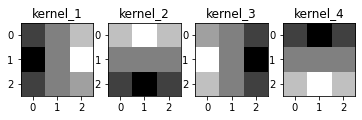

In [ ]:
kernel_1 = np.array([[-1,0,1],[-2, 0, 2], [-1, 0, 0.5]])
kernel_2 = np.array([[1,2,1],[0, 0, 0], [-1, -2, -1]])
kernel_3 = rotate180(kernel_1)
kernel_4 = rotate180(kernel_2)

for i in range(1, 5):
    kernel = eval(f'kernel_{i}')
    ax = plt.subplot(1, 4, i)
    ax.imshow(kernel, cmap='gray')
    ax.set_title(f'kernel_{i}')
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))

**Q1. Implement the convolution operation in a naive 4 nested for-loops, and use it to get the convolved image with the filters above.**

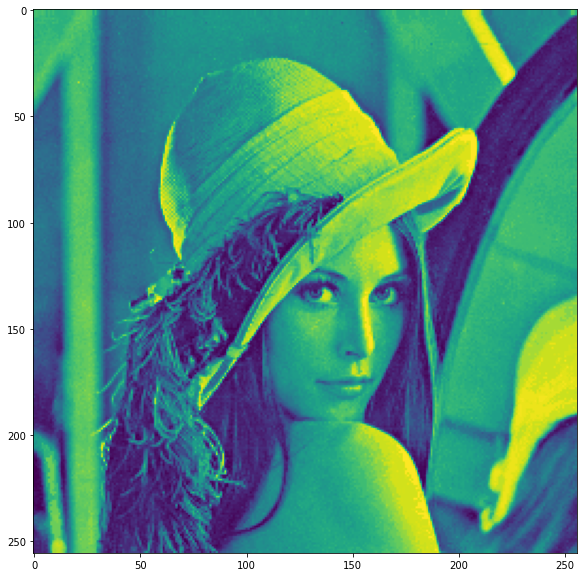

In [ ]:
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots

image_grey_sample_file = 'image_grey_sample.npy'
image_grey_sample = np.load(image_grey_sample_file)
plt.imshow(image_grey_sample)

In [ ]:
def conv2d(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """Implement the convolution operation in a naive 4 nested for-loops.

    Args:
        image (np.ndarray)
        kernel (np.ndarray)

    Returns:
        conv_output (np.ndarray)
    """

    # Initiate all the params
    padding = 0                     # padding
    stride = 1                      # Stride

    kernel_num = kernel.shape[0]    # Kernel number
    kernel_length = kernel.shape[1] # kernel width

    image_num = image.shape[0]      # number of inputs

    input_height = image.shape[1]   # input height and width
    input_width = image.shape[2]    # input width

    output_height = math.floor((input_height - kernel_length + 2 * padding) / stride) + 1   # output height
    output_width = math.floor((input_width - kernel_length + 2 * padding) / stride) + 1     # output width
    
    conv_output = np.zeros((image_num, output_height, output_width, kernel_num))

    print(f'{image_num} image with shape {input_height} * {input_width}')
    print(f'{image_num} kernel with shape {kernel_length} * {kernel_length}')
    print(f'Process Convolution with {image_num} padding and {kernel_length} stride')

    
    # Iterate over inputs
    for i in range(image_num): 
        # Iterate over output height
        for h in range(output_height):
            ih1 = h * stride # calculate input window height coordinates
            ih2 = ih1 + kernel_length
            # Iterate over output width
            for w in range(output_width): 
                iw1 = w * stride # calculate input window width coordinates
                iw2 = iw1 + kernel_length
                # Iterate over filters
                for f in range(kernel_num):
                    conv_output[i, h, w, f] = np.sum(image[i, ih1:ih2, iw1:iw2] * kernel[f, :, :]) # Calculate output
    return conv_output

In [ ]:
# Make image 3 dimension: images number, height, width
image_input = np.expand_dims(image_grey_sample, axis=0)
print(f'Image Sample Dimension: {image_grey_sample.shape}')
print(f'Image Input Dimension: {image_input.shape}')

# Stack four kernel into one Numpy with 3 dimension
kernel = np.stack(([kernel_1, kernel_2, kernel_3, kernel_4]), axis = 0)
print(f'Kernel Input Dimension: {kernel.shape}')

Image Sample Dimension: (256, 256)
Image Input Dimension: (1, 256, 256)
Kernel Input Dimension: (4, 3, 3)


1 image with shape 256 * 256
1 kernel with shape 3 * 3
Process Convolution with 1 padding and 3 stride


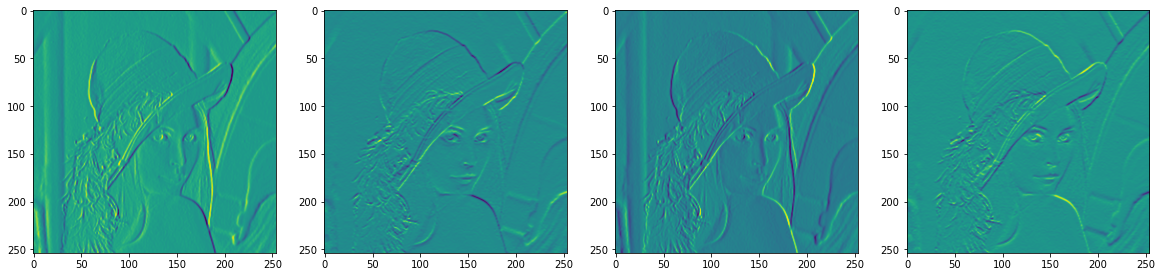

In [ ]:
conv_output = conv2d(image_input, kernel)

# Visualize convalutional of all kernel
image_num = conv_output.shape[0]
kernel_num = conv_output.shape[-1]
fig, axes = plt.subplots(image_num, kernel_num, figsize=(20, 20))
for idx, ax in enumerate(axes.flat):
    ax.imshow(conv_output[idx//4, :, :, idx%4])

**Q2. A faster implementation of convolution is originated from the collapse of the most inner loops with the matrix operation. Try to implement it and test the effects.**


Tips: Pad the image first.

In [ ]:
def pad_zeros(image: np.ndarray, pad_height: int, pad_width: int) -> np.ndarray:
    """Pad the image with zero pixels, e.g., given matrix [[1]] with pad_height=1 and pad_width=2, obtains:
       [[0 0 0 0 0]
       [0 0 1 0 0]
       [0 0 0 0 0]]

    Args:
        image (np.ndarray)
        pad_height (int)
        pad_width (int)

    Returns:
        padded_output (np.ndarray)
    """
    






    return padded_image

Then flip the kernel by angle 180 and do the element-wise multiplication between the kernel and the image regions.

In [ ]:
def conv2d_fast(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """Pad the image first and then flip the kernel by angle 180
       and do element-wise multiplication between the kernel and the image regions.

    Args:
        image (np.ndarray)
        kernel (np.ndarray)

    Returns:
        conv_output (np.ndarray)
    """

    









    

    return conv_output 

Import the `time` built-in library to measure the consumption of time used by different convolution implementations.

In [ ]:
import time







assert np.max(np.abs(image_conv - image_conv_fast)) < 1e-10





Native 4 nested loop: 0.7023658752441406
Fast version: 0.49739933013916016


**Q3. A faster++ version of convolution is required to implement here. Test it afterwards as well.**

Tips: Pad the image first and then pre-extract all the regions of kernel size, and arrange them into a matrix of shape ($H_i\times W_i$, $H_k\times W_k$),also arrage the flipped kernel to be of shape ($H_k\times W_k$, 1), then do matrix multiplication.

In [ ]:
def conv2d_faster(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """Pad the image first and then pre-extract all the regions of kernel size,
       and arrange them into a matrix of shape (Hi*Wi, Hk*Wk),also arrage the flipped
       kernel to be of shape (Hk*Wk, 1), then do matrix multiplication.
    
    Args:
        image (np.ndarray)
        kernel (np.ndarray)

    Returns:
        conv_output (np.ndarray)
    """
    











    

    return conv_output

Test the running time.

In [ ]:





assert np.max(np.abs(image_conv - image_conv_faster)) < 1e-10






Native 4 nested loop: 0.7023658752441406
Fast version: 0.49739933013916016
Faster version: 0.11687660217285156
